In [1]:
!pip install pypdf
!pip install fonttools
!pip install pdf2image

In [1]:
import re
import pypdf

from fontTools.ttLib import TTFont
from fontTools.ttLib.tables._c_m_a_p import CmapSubtable

from pdf2image import convert_from_path, convert_from_bytes

from PIL import ImageDraw, Image

In [6]:
FILENAME = 'src/03100000.pdf'
#FILENAME = 'src/04810000.pdf'

In [2]:
def fix_text(s):
    s = re.sub(r'([a-zA-Z0-9]) (?=[a-zA-Z0-9])',r'\1  ',s)
    items = s.split("  ")
    s1 = ' '.join([i.replace(" ","") for i in items])
    
    flist = [
        (" า", "ำ"),
        (" ่า", "่ำ"),
        (" ้า", "้ำ"),
        (" ๊า", "๊ำ"),
        (" ๋า", "๋ำ"),
    ]
    for a,b in flist:
        s1 = s1.replace(a,b)
    return s1

In [3]:
font = TTFont('/home/jittat/Downloads/upcdl.ttf')
cmap = font['cmap']
tcmap = cmap.getcmap(3,1).cmap
glyphset = font.getGlyphSet()
units_per_em = font['head'].unitsPerEm

def getTextWidth(text,pointSize):
    total = 0
    for c in text:
        if ord(c) in tcmap and tcmap[ord(c)] in glyphset:
            total += glyphset[tcmap[ord(c)]].width
        else:
            total += glyphset['.notdef'].width
    total = total*float(pointSize)/units_per_em;
    return total

In [4]:
pdf_images = {}

def get_pdf_image(page):
    BUFSIZE = 20
    if page not in pdf_images:
        pdf_images.clear()
        fr = page+1
        to = page+BUFSIZE
        #print('reading from page', fr, 'to', to)
        new_images = convert_from_path(FILENAME,first_page=fr,last_page=to)
        c = page
        for img in new_images:
            pdf_images[c] = img
            c += 1
        
    return pdf_images[page].copy()

In [7]:
parts = []

ys = []
xs = []
xys = []

def visitor_body(text, cm, tm, fontDict, fontSize):
    #t = text.replace(" ","")
    #if t.strip() == '':
    #    return
    
    #print(text,cm,tm)
    
    t = fix_text(text).strip()
    if t != '':
        #print(t,cm,tm,fontSize)
        w = getTextWidth(t, fontSize)/72
        #print(t,fontSize,w)
        if tm[4]/72 > 7.05:
            w = 0
        
        ys.append((tm[5]/72,t))
        xs.append((tm[4]/72 - w,t))
        xys.append({
            'org_x': tm[4],
            'org_y': tm[5],
            'x': tm[4]/72,
            'estimated_x': tm[4]/72 - w,
            'y': tm[5]/72,
            'str': t,
        })
        parts.append((text,cm,tm,fontSize))

def group_lines(xys):
    sorted_sts = sorted([(-items['y'],i,items) for i,items in enumerate(xys)])
    
    prev = -1
    line = []
    lines = []
    for y, _, item in sorted_sts:
        if y < prev + 0.1:
            line.append(item)
        else:
            if line != []:
                lines.append([item for _,_,item in sorted([(item['x'],idx,item) for idx,item in enumerate(line)])])
            line = []
            line.append(item)
        prev = y
    if line != []:
        lines.append([item for _,_,item in sorted([(item['x'],idx,item) for idx,item in enumerate(line)])])
    return lines

def is_start_line(line):
    return ' '.join([i['str'] for i in line]) == 'รายการ หน่วยนับ ปริมาณ งบประมาณ'

def split_base_columns(line):
    sep = [5.6, 6.3, 6.7]
    
    cols = [[],[],[],[]]
    for i in line:
        x = i['estimated_x']
        c = len([s for s in sep if s < x])
        cols[c].append(i)
    return cols

def compute_image_location(org_x, org_y, page_height):
    # TODO: very hacky calculation
    
    XSCALE = 2.8087
    YSCALE = 2.7862
    x = org_x * XSCALE
    y = (org_y * YSCALE)
    y = 201 + (y-201)/1.002785
    y = page_height - y
    return x,y

def find_indent(image, y1, y2):
    start = 45
    skip = 1
    found = False
    y1 = int(y1)
    y2 = int(y2)
    
    current_x = start
    
    THRES = 66
    while not found:
        for y in range(y1,y2+1):
            if max(image.getpixel((current_x,y))) < THRES:
                return current_x
        current_x += skip

reader = pypdf.PdfReader(open(FILENAME,'rb'))

rows = []

all_indents = set()

counter = 0
for page in reader.pages:
    parts = []

    ys = []
    xs = []
    xys = []

    counter += 1
    page.extract_text(visitor_text=visitor_body)
    
    page_image = get_pdf_image(counter-1)
    page_draw = ImageDraw.Draw(page_image)
    page_height = page_image.height
        
    lines = group_lines(xys)
    started = False
    for line in lines:
        if started:
            cols = split_base_columns(line)
            #print(' '.join([i['str'] for i in line]))
            
            pixel_indent = 0
            for word in cols[0]:
                x,y = compute_image_location(word['org_x'], word['org_y'], page_height)
                #page_draw.rectangle([x-20, y-10, x, y],
                #                    fill='red')
                pixel_indent = find_indent(page_image, y-10,y)
                
                #page_draw.rectangle([pixel_indent, y-10, pixel_indent+5,y], fill=(0,255,0))

                all_indents.add(pixel_indent)
                break

            rows.append({
                'columns': cols,
                'pixel_indent': pixel_indent
            })

                
        if is_start_line(line):
            started = True
    
    if counter % 10 == 0:
        print(counter)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230


#### type(page_image)

In [112]:
page_image.height, page_image.width

(2339, 1654)

In [83]:
2239/(11.7*72)

2.6578822412155745

In [84]:
297/210

1.4142857142857144

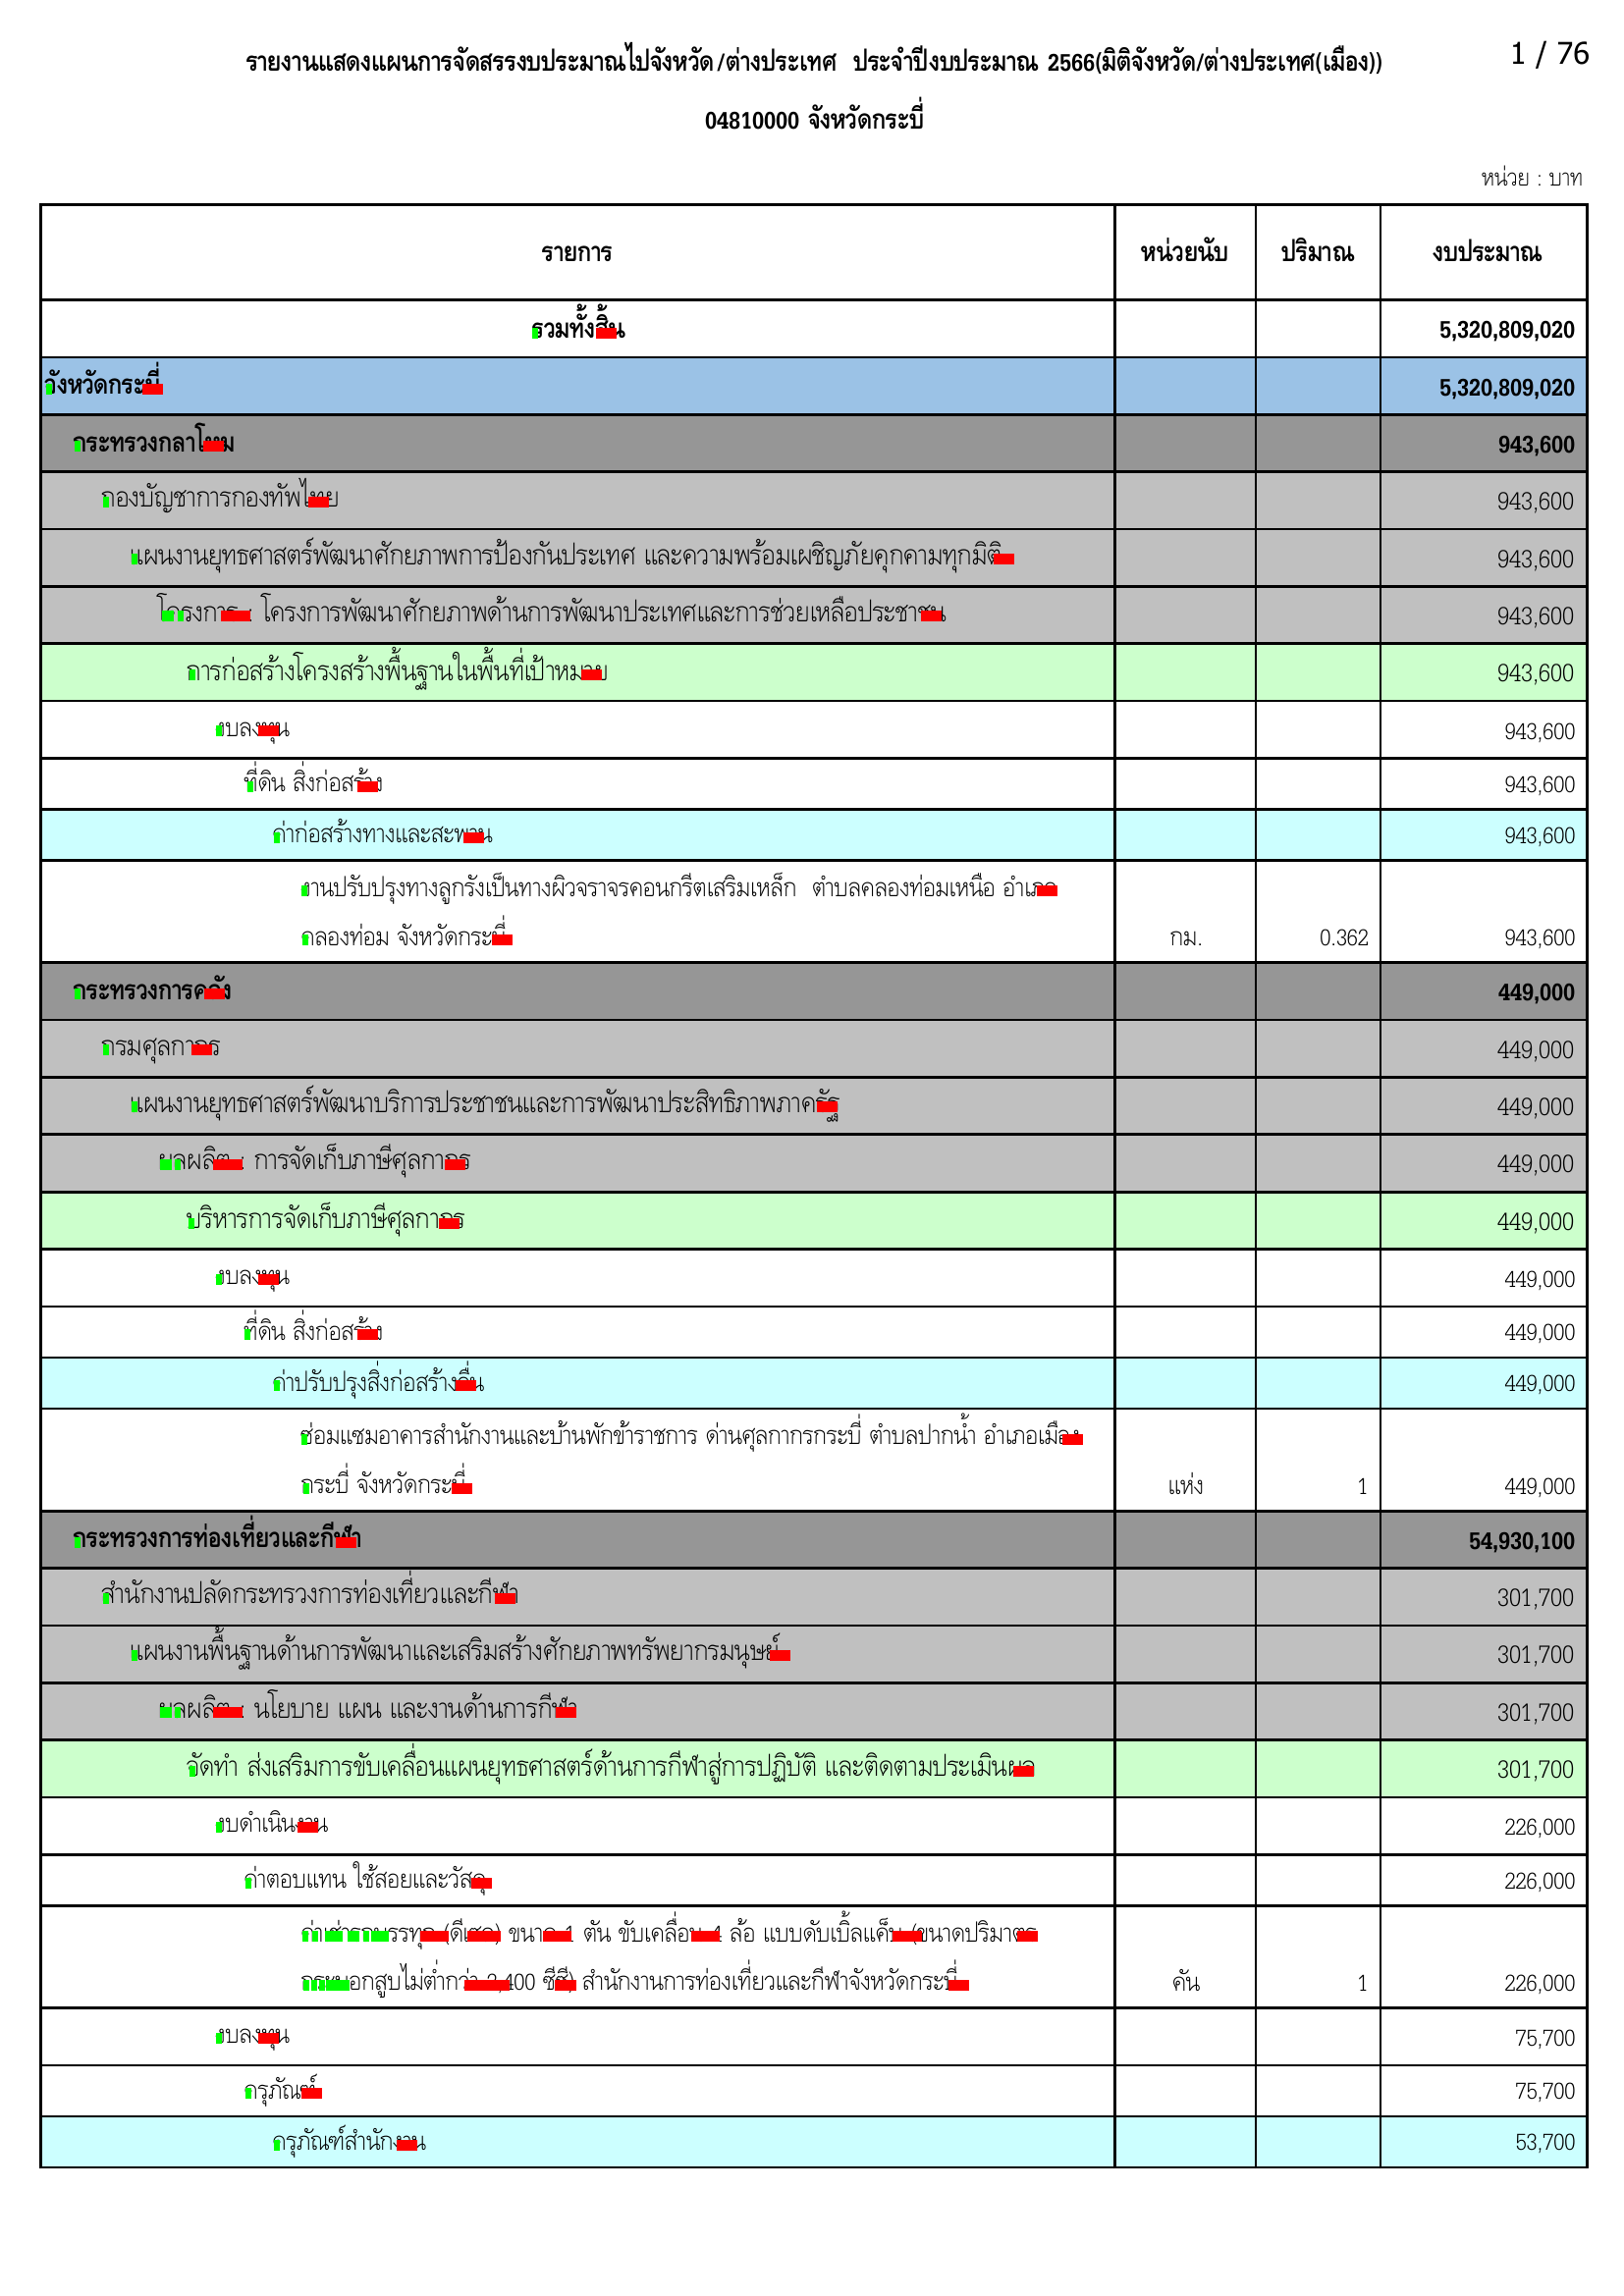

In [140]:
page_image

In [126]:
[(x,page_image.getpixel((x,300))) for x in range(30,60)]

[(30, (255, 255, 255)),
 (31, (255, 255, 255)),
 (32, (255, 255, 255)),
 (33, (255, 255, 255)),
 (34, (255, 255, 255)),
 (35, (255, 255, 255)),
 (36, (255, 255, 255)),
 (37, (255, 255, 255)),
 (38, (255, 255, 255)),
 (39, (255, 255, 255)),
 (40, (0, 0, 0)),
 (41, (0, 0, 0)),
 (42, (0, 0, 0)),
 (43, (255, 255, 255)),
 (44, (255, 255, 255)),
 (45, (255, 255, 255)),
 (46, (255, 255, 255)),
 (47, (255, 255, 255)),
 (48, (255, 255, 255)),
 (49, (255, 255, 255)),
 (50, (255, 255, 255)),
 (51, (255, 255, 255)),
 (52, (255, 255, 255)),
 (53, (255, 255, 255)),
 (54, (255, 255, 255)),
 (55, (255, 255, 255)),
 (56, (255, 255, 255)),
 (57, (255, 255, 255)),
 (58, (255, 255, 255)),
 (59, (255, 255, 255))]

In [196]:
len(all_indents)

58

In [197]:
print(sorted(all_indents))

[48, 74, 75, 76, 104, 105, 106, 108, 134, 161, 162, 163, 164, 165, 166, 167, 171, 172, 190, 191, 192, 193, 194, 195, 196, 200, 201, 202, 203, 204, 220, 249, 250, 251, 252, 278, 279, 280, 282, 307, 308, 309, 310, 311, 312, 315, 316, 317, 318, 319, 320, 324, 325, 327, 332, 333, 340, 542]


In [198]:
pdf_images.keys()

dict_keys([1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231])

In [9]:
p = pdf_images[1221].copy()
marks = [
    47,
    74,
    104,
    134,
    163,
    190,
    220,
    249,
    279,
    307,
    340,
]
SEP = []
om = marks[0]
for m in marks[1:]:
    SEP.append((om*0.3 + m*0.7))
    om = m
d = ImageDraw.Draw(p)
for s in marks:
    d.rectangle([s,0,s,page_image.height], fill='green')
for s in SEP:
    d.rectangle([s,0,s,page_image.height], fill='blue')

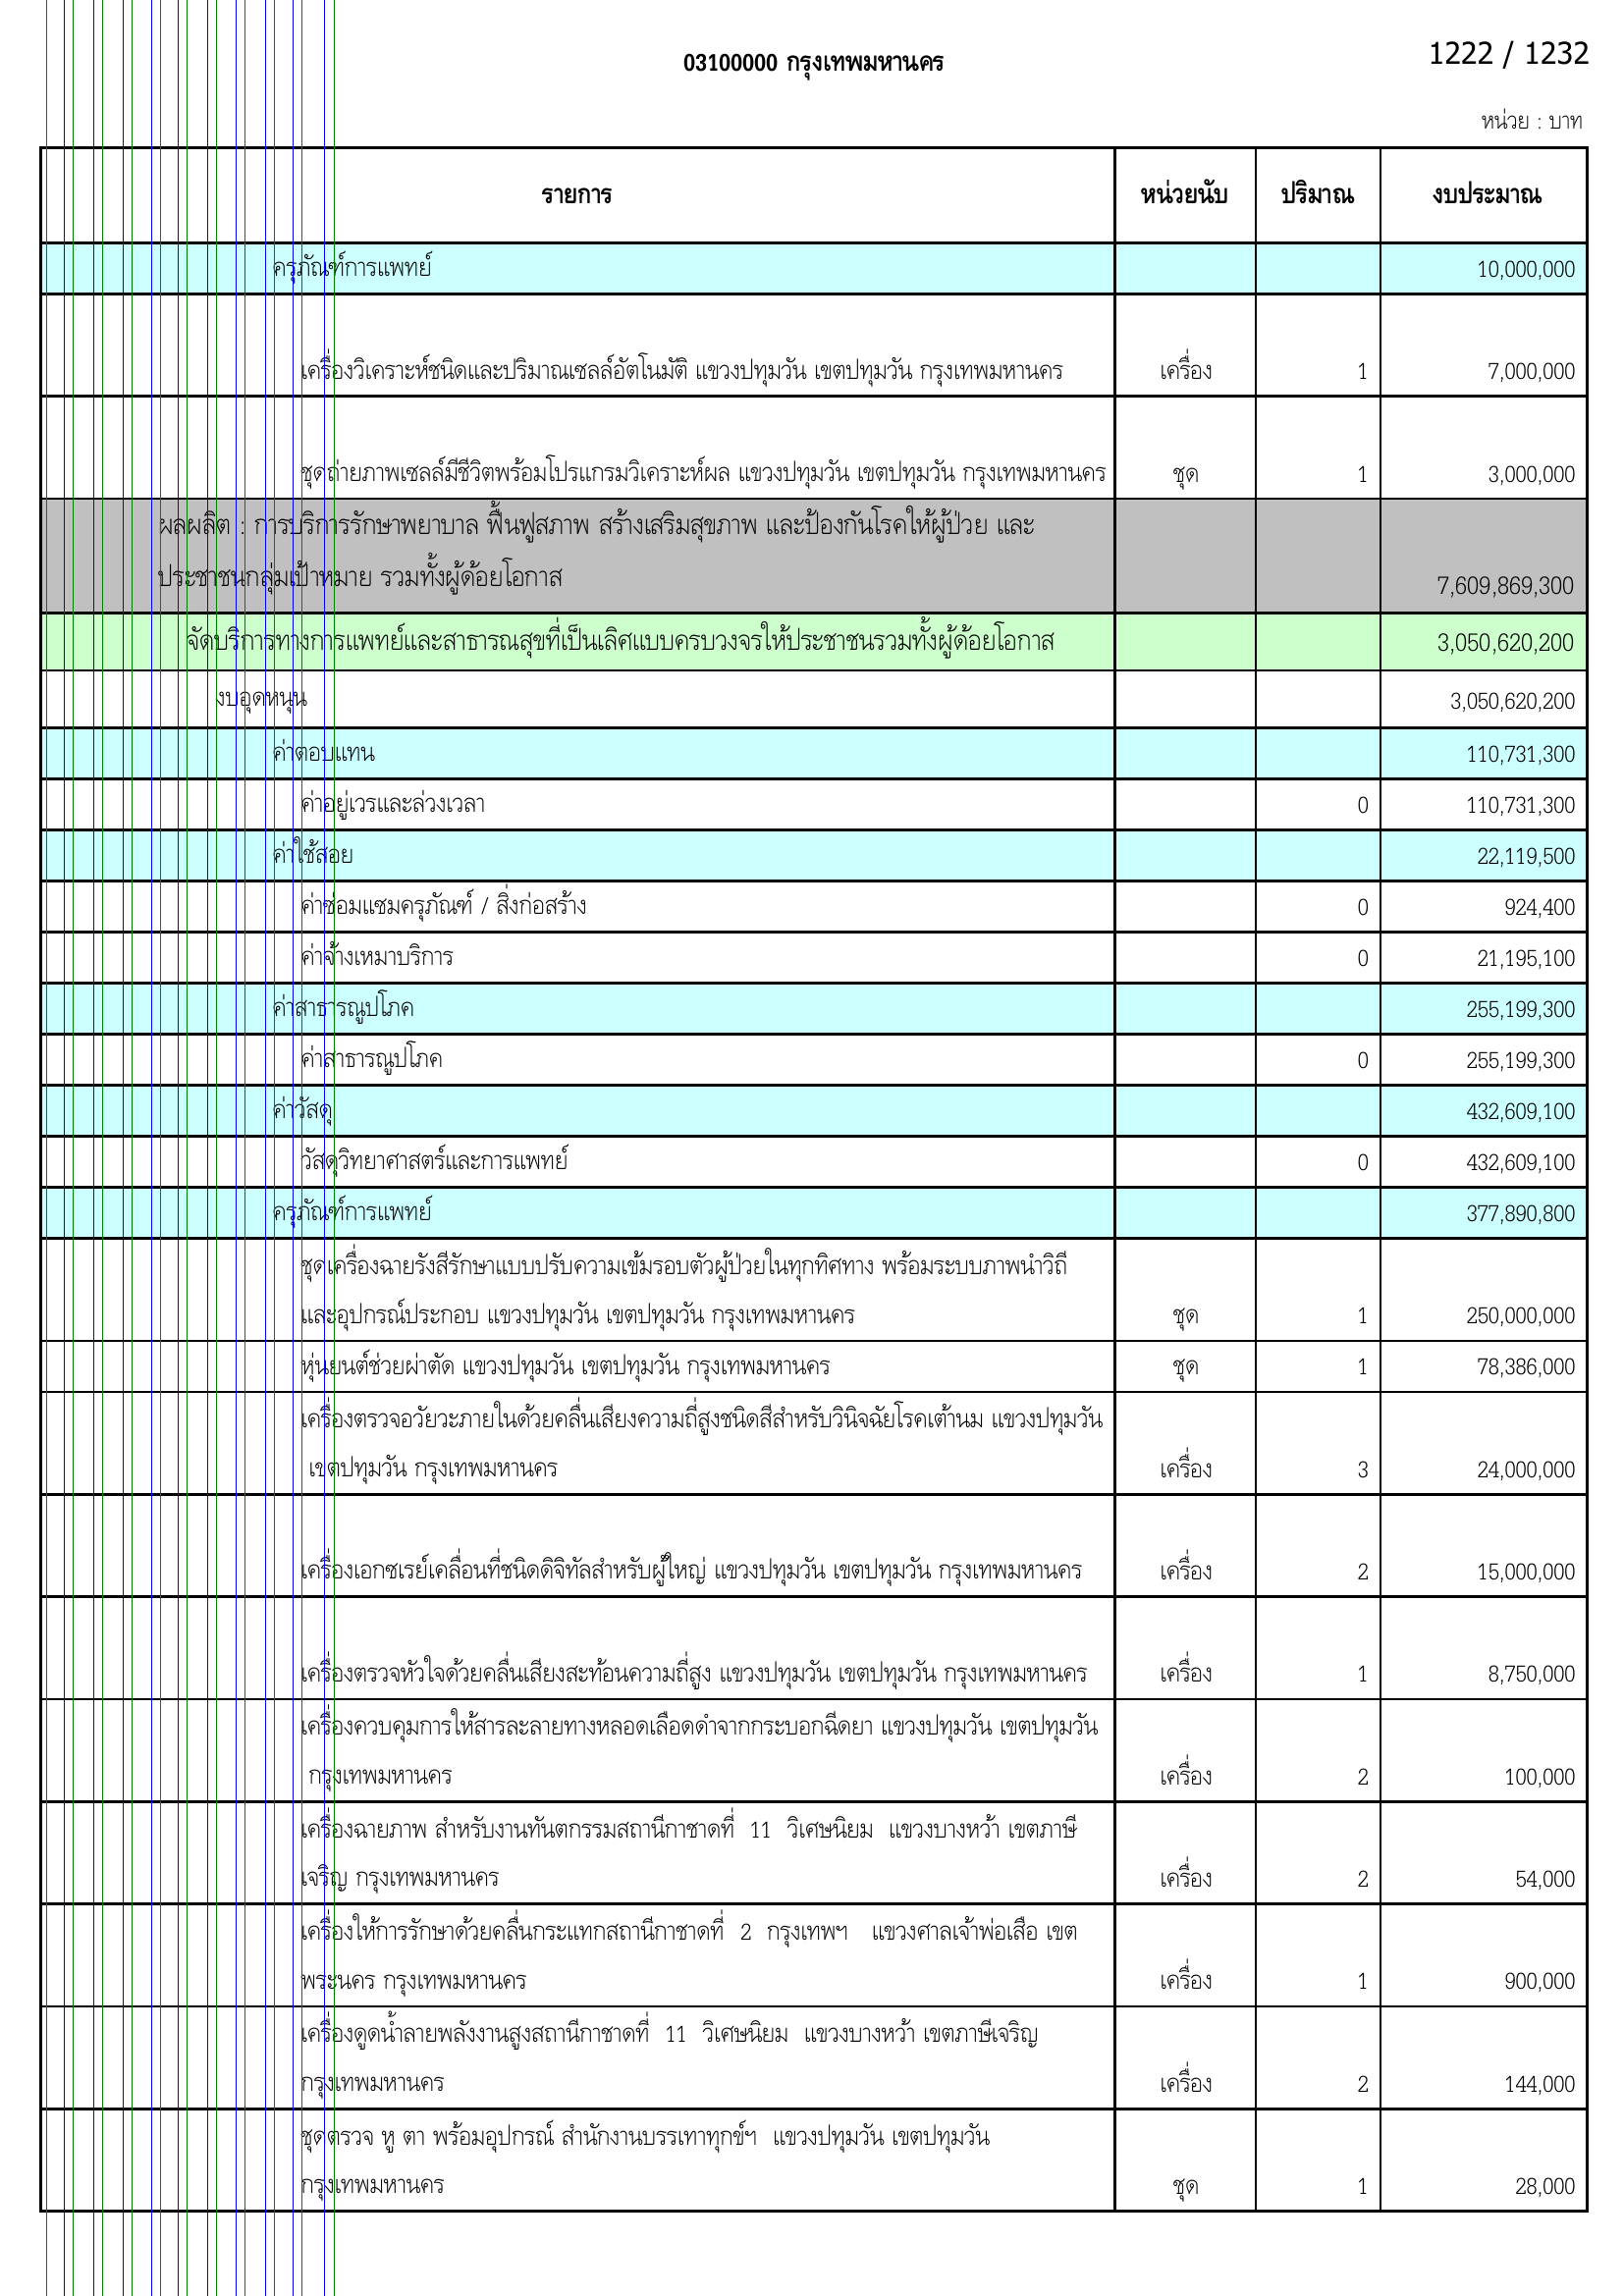

In [202]:
p

In [13]:
MAX_INDENT = 9
UNIT_COL_INDEX = MAX_INDENT+1
COUNT_COL_INDEX = MAX_INDENT+2
AMOUNT_COL_INDEX = MAX_INDENT+3

def find_indent(pixel_indent):
    #print(item)
    return len([s for s in SEP if s < pixel_indent])

output = []
prev_indent = 0
for row in rows:
    if len(row['columns'][0])!= 0:
        indent = find_indent(row['pixel_indent'])
        output.append((indent,row['columns']))
        prev_indent = indent
    else:
        output.append((prev_indent,row['columns']))

In [29]:
csv_rows = []

item_values = []
for indent,cols in output:
    c1,c2,c3,c4 = cols
    items = [""] * (MAX_INDENT+4)
    
    if len(c3)==0 and len(c4)==2:
        c3=[c4[0]]
        c4=[c4[1]]

    if len(c3)==0 and len(c2)==2:
        c3=[c2[1]]
        c2=[c2[0]]
    
    title, unit, count, amount = [' '.join([item['str'] for item in col]) for col in [c1,c2,c3,c4]]
    
    items[indent] = title
    items[UNIT_COL_INDEX] = unit
    items[COUNT_COL_INDEX] = count
    items[AMOUNT_COL_INDEX] = amount
    
    if amount.strip() != '' and title.strip() == '' and ((len(csv_rows)!=0) and (csv_rows[-1][MAX_INDENT+3].strip() =='')):
        csv_rows[-1][MAX_INDENT+3] = amount

        item_values[-1][2] = float(amount.replace(",",""))
    else:
        csv_rows.append(items)

        if amount.strip()!= '':
            item_values.append([indent,title, float(amount.replace(",",""))])
        else:
            item_values.append([indent,title,None])

In [30]:
def clean_empty_rows(rows):
    output_rows = []
    #count = 0
    for items in rows:
        if (len(output_rows)!=0):
            last_row = output_rows[-1]
            if (last_row[AMOUNT_COL_INDEX].strip() == '') and (items[AMOUNT_COL_INDEX].strip() != ''):
                # combine row
                if last_row[COUNT_COL_INDEX].strip() != '':
                    print('ERROR:', last_row)
                for i,x in enumerate(items):
                    last_row[i] += items[i]
                output_rows[-1] = last_row
            else:
                output_rows.append(items)
        else:
            output_rows.append(items)
        #print(items)
        #count += 1
        #if count == 100:
        #    break
    return output_rows

def add_header(rows):
    rows[0][0] = 'รวมทั้งสิ้น'
    header = [""] * (MAX_INDENT+4)
    header[0] = 'รายการ'
    header[UNIT_COL_INDEX] = 'หน่วยนับ'
    header[COUNT_COL_INDEX] = 'ปริมาณ'
    header[AMOUNT_COL_INDEX] = 'งบประมาณ'
    return [header] + rows

In [31]:
import csv
with open('test3.csv','w') as fout: 
    writer = csv.writer(fout)
    cleaned_csv_rows = add_header(clean_empty_rows(csv_rows))
    for r in cleaned_csv_rows:
        writer.writerow(r)

# Validation code

Validation by cross checking the budget sum in subcategories.  Doesn't seem to work well as the original data contains possibly some errors.

In [210]:
MAX_LEVEL = 20

def build_tree(item_values):
    counter = 0
    active_nodes = {}
    for l in range(MAX_LEVEL):
        active_nodes[l] = None
        
    for level,item,value in item_values:
        counter += 1
        new_node = {
            'counter': counter,
            'level': level,
            'item': item,
            'value': value,
            'children': [],
            'is_dummy': False,
        }
        if level == 0:
            if active_nodes[0] != None:
                level = 1
        if level != 0:
            if active_nodes[level-1] == None:
                for l in range(level):
                    if active_nodes[l] == None:
                        dummy = {
                            'is_dummy': True,
                            'level': l,
                            'children': [],
                        }
                        active_nodes[l-1]['children'].append(dummy)
                        active_nodes[l] = dummy
            active_nodes[level-1]['children'].append(new_node)
        active_nodes[level] = new_node
        for l in range(level+1, MAX_LEVEL+1):
            active_nodes[l] = None
        
    return active_nodes[0]

root = build_tree(item_values[1:])

In [216]:
def fix_dummy(node):
    for c in node['children']:
        fix_dummy(c)
    if node['is_dummy']:
        node['value'] = sum([c['value'] for c in node['children'] if c['value'] != None])
        

In [217]:
def check_node(node):
    target = node['value']
    if (target != None) and (len(node['children'])!=0):
        
        s = sum([c['value'] for c in node['children'] if c != None and c['value']!=None])
        if s != target:
            if s > target:
                print("<<<", node['counter'], node['item'], node['level'], target, s)
            else:
                print(">>>", node['counter'], node['item'], node['level'], target, s)
    for c in node['children']:
        check_node(c)

In [218]:
fix_dummy(root)

In [219]:
check_node(root)

<<< 15 ค่าตอบแทน ใช้สอยและวัสดุ 7 6209200.0 6709200.0
<<< 96 ค่าตอบแทน ใช้สอยและวัสดุ 7 1960100.0 3385100.0
<<< 119 ค่าตอบแทน ใช้สอยและวัสดุ 7 32018000.0 41207200.0
<<< 146 ค่าตอบแทน ใช้สอยและวัสดุ 7 41749400.0 81418800.0
<<< 264 ค่าตอบแทนพนักงานราชการ 7 140372300.0 280871600.0
<<< 318 ค่าตอบแทน ใช้สอยและวัสดุ 7 190899500.0 229899500.0
<<< 520 งบรายจ่ายอื่น 6 2173840400.0 2731893400.0
<<< 733 เงินเดือนและค่าจ้างประจำ 7 120008400.0 128500000.0
<<< 754 ค่าตอบแทน ใช้สอยและวัสดุ 7 67291200.0 96107700.0
<<< 816 ค่าตอบแทน ใช้สอยและวัสดุ 7 19417000.0 37207500.0
<<< 830 ค่าตอบแทน ใช้สอยและวัสดุ 7 12345500.0 23394500.0
<<< 858 ค่าตอบแทน ใช้สอยและวัสดุ 7 2426100.0 4481300.0
<<< 1006 ค่าตอบแทน ใช้สอยและวัสดุ 7 16316200.0 30863700.0
<<< 1033 ค่าตอบแทน ใช้สอยและวัสดุ 7 26849300.0 49879200.0
<<< 1049 ค่าสาธารณูปโภค 7 11865100.0 23730200.0
<<< 1109 ครุภัณฑ์คอมพิวเตอร์ 8 231411800.0 462823600.0
<<< 1120 ค่าตอบแทน ใช้สอยและวัสดุ 7 101755800.0 189183300.0
<<< 1150 ค่าสาธารณูปโภค 7 50397400.0 50497400.0
